# Imports

In [1]:
from pathlib import Path
from pathlib import Path
import json

import pandas as pd
import matplotlib.pyplot as plt

# Load data

In [2]:
results = list()
for elem in Path("src/results").glob("*.json"):
    with open(elem, "r") as f:
        results.append(json.load(f))

In [3]:
df = pd.json_normalize(results)
df.shape

(2430, 10)

### Validate number of executions

In [4]:
df.groupby(["dataset", "model", "neurons"]).agg({"neurons": "count"}).mean()

neurons    30.0
dtype: float64

# Plot scatter of all executions

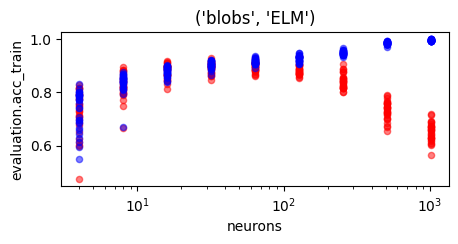

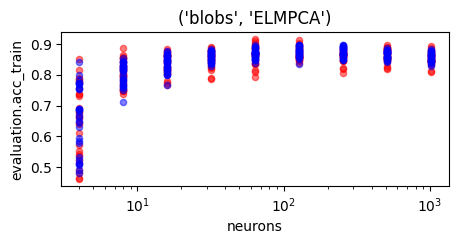

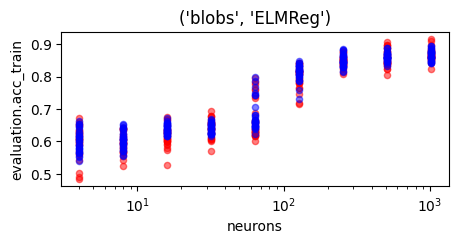

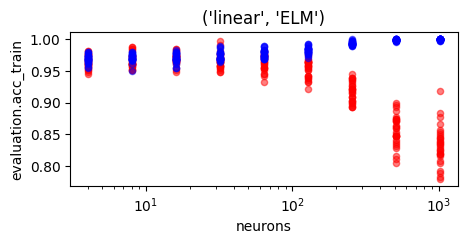

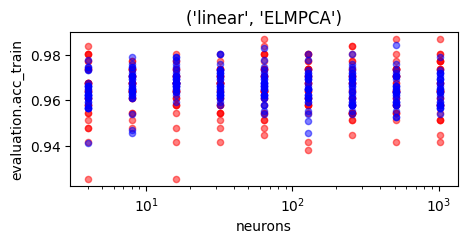

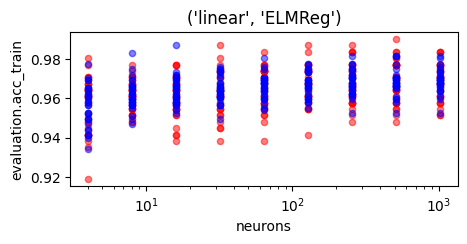

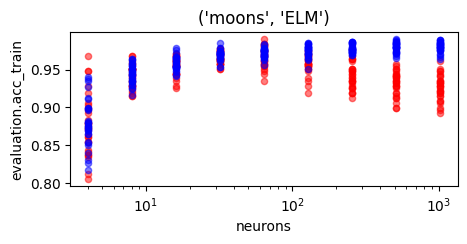

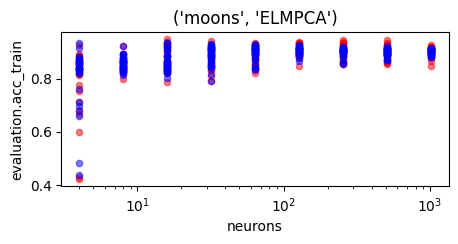

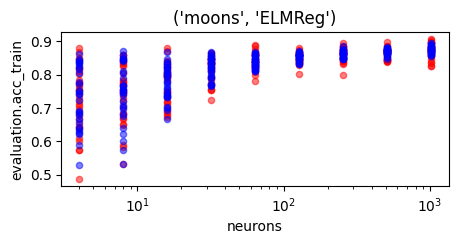

In [5]:
for name, group in df.groupby(["dataset", "model"]):
    plt.figure(figsize=(5, 2))
    ax = plt.gca()
    group.plot.scatter(
        x="neurons", y="evaluation.acc_test",
        color="red", alpha=.5, ax=ax,
    )
    group.plot.scatter(
        x="neurons", y="evaluation.acc_train",
        color="blue", alpha=.5, ax=ax,
    )
    plt.xscale("log")
    plt.title(name)
    plt.show()
    plt.close()

# Plot average metrics

In [6]:
means = (
    df
    .groupby(["dataset", "model", "neurons"], as_index=False)
    .agg({
        "evaluation.acc_train": "mean",
        "evaluation.acc_test": "mean",
        "evaluation.time_to_fit": "mean",
    })
)

means["evaluation.acc_diff"] = means["evaluation.acc_test"] - means["evaluation.acc_train"]

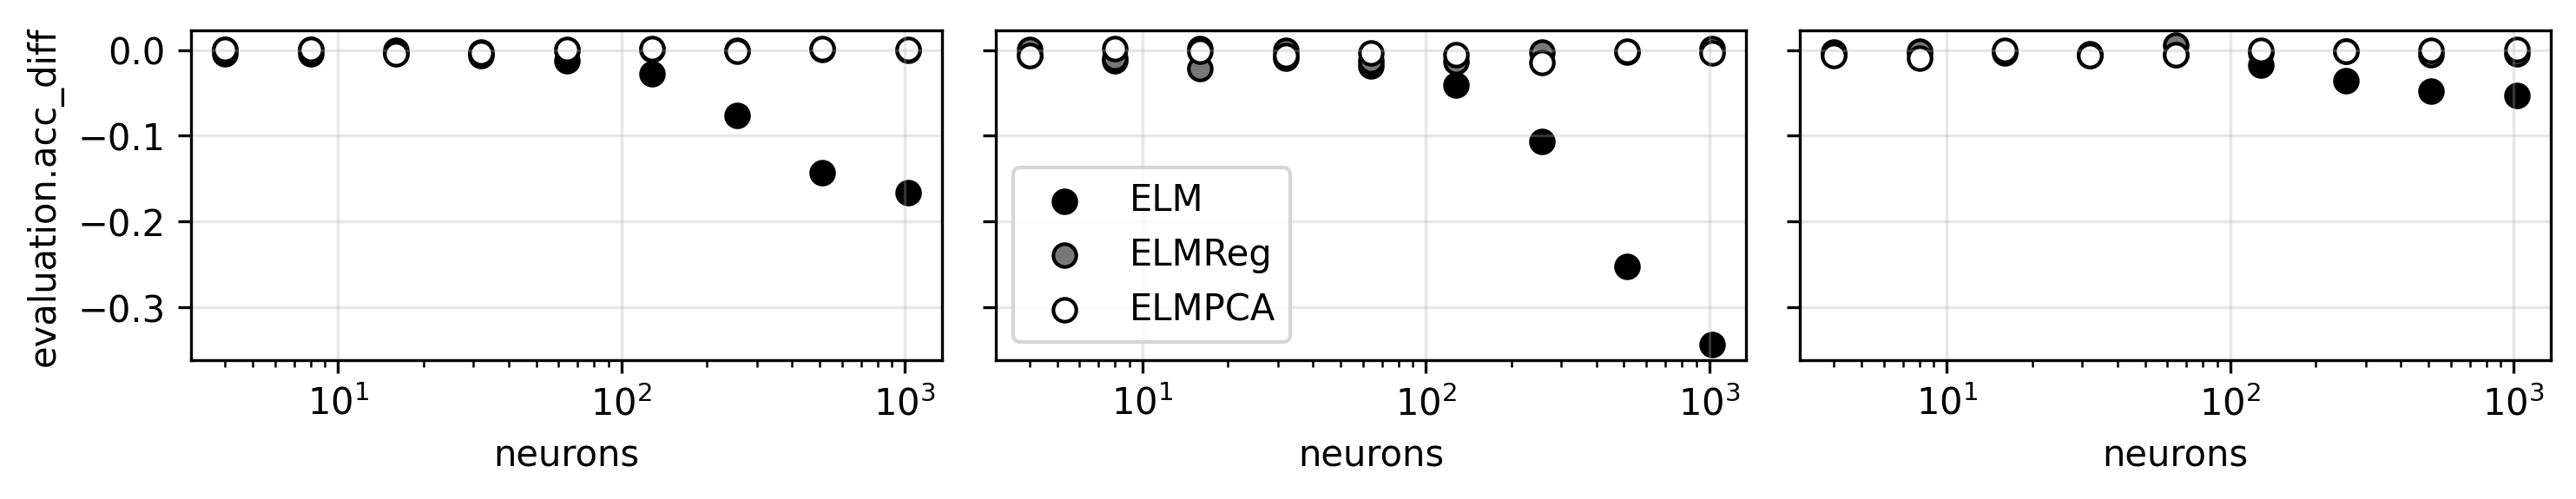

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(10, 2), dpi=300, sharex=True, sharey=True)

for i, dataset in enumerate(["linear", "blobs", "moons"]):
    for (model, color) in [("ELM", "#000000"), ("ELMReg", "#777777"), ("ELMPCA", "#FFFFFF")]:
        means[
            (means["dataset"] == dataset)
            & (means["model"] == model)
        ].plot.scatter(x="neurons", y="evaluation.acc_diff", color=color, edgecolors="black", ax=ax[i], s=40, label=model)
        ax[i].grid(alpha=.3)
        ax[i].get_legend().remove()

ax[1].legend()
plt.xscale("log")
plt.tight_layout()
plt.savefig("metrics.pdf")

# Pivot metrics

In [8]:
means[means["neurons"] == 1024].round(3)[[
    "dataset", "model",
    "evaluation.acc_train", "evaluation.acc_test", "evaluation.acc_diff", "evaluation.time_to_fit"
]]

,dataset,model,evaluation.acc_train,evaluation.acc_test,evaluation.acc_diff,evaluation.time_to_fit
8,blobs,ELM,0.996,0.651,-0.344,0.221
17,blobs,ELMPCA,0.858,0.854,-0.004,2.733
26,blobs,ELMReg,0.866,0.868,0.002,0.359
35,linear,ELM,0.999,0.833,-0.167,0.209
44,linear,ELMPCA,0.964,0.965,0.001,2.861
53,linear,ELMReg,0.969,0.969,-0.000,0.360
62,moons,ELM,0.980,0.927,-0.053,0.200
71,moons,ELMPCA,0.901,0.901,0.001,2.714
80,moons,ELMReg,0.875,0.870,-0.004,0.367


In [38]:
means[means["neurons"] == 32].round(3)[[
    "dataset", "model",
    "evaluation.acc_train", "evaluation.acc_test", "evaluation.acc_diff", "evaluation.time_to_fit"
]]

,dataset,model,evaluation.acc_train,evaluation.acc_test,evaluation.acc_diff,evaluation.time_to_fit
3,blobs,ELM,0.904,0.894,-0.009,0.002
12,blobs,ELMPCA,0.859,0.853,-0.006,0.003
21,blobs,ELMReg,0.640,0.640,-0.000,0.001
30,linear,ELM,0.973,0.966,-0.007,0.002
39,linear,ELMPCA,0.968,0.965,-0.003,0.003
48,linear,ELMReg,0.965,0.962,-0.002,0.002
57,moons,ELM,0.970,0.965,-0.004,0.002
66,moons,ELMPCA,0.886,0.879,-0.007,0.003
75,moons,ELMReg,0.823,0.816,-0.007,0.001


# Compare `ELMReg` with `ELMPCA`

In [26]:
cmp = means.pivot(columns="model", index=["dataset", "neurons"], values=["evaluation.acc_test"])
cmp

evaluation.acc_test                    
model                           ELM    ELMPCA    ELMReg
dataset neurons                                        
blobs   4                  0.725433  0.653355  0.600758
        8                  0.824784  0.804870  0.596320
        16                 0.880952  0.835606  0.617100
        32                 0.894372  0.852814  0.640152
        64                 0.896645  0.865152  0.666450
        128                0.886797  0.868615  0.800000
        256                0.842532  0.860065  0.847403
        512                0.732792  0.863853  0.857900
        1024               0.651299  0.853896  0.868182
linear  4                  0.964610  0.963745  0.956710
        8                  0.966450  0.966342  0.961905
        16                 0.969697  0.964177  0.960281
        32                 0.966234  0.964610  0.962446
        64                 0.963853  0.966775  0.965476
        128                0.954113  0.966342  0.967208
        256                0.916883  0.964069  0.967532
        512                0.855844  0.966234  0.969156
        1024               0.832792  0.965043  0.968723
moons   4                  0.877597  0.795996  0.724784
        8                  0.941450  0.848593  0.742100
        16                 0.954762  0.866126  0.775866
        32                 0.965368  0.878571  0.816126
        64                 0.966991  0.890693  0.842208
        128                0.957143  0.903247  0.850000
        256                0.941667  0.899134  0.860281
        512                0.931926  0.898701  0.862987
        1024               0.926515  0.901299  0.870238

---